In [2]:
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf

import time
import pickle
from matplotlib.ticker import MaxNLocator

import pandas as pd
np.set_printoptions(suppress=True,precision=3)
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

import sys

from tensorflow_probability import distributions as tfd
%matplotlib inline


In [6]:
burn=0
num_runs=1
num_samples=1500
all_lengths = np.zeros(((num_samples-burn)*num_runs,200,1))
all_amps = np.zeros(((num_samples-burn)*num_runs,200,1))

for i in range(num_runs):
    lengths =np.load('../data/full_len_sheep_p_' + str(i) + '.npy')
    amps =  np.load('../data/full_amp_sheep_p_' + str(i) + '.npy')
    all_lengths[i*(num_samples-burn):(i+1)*(num_samples-burn),...] = lengths[burn::1]
    all_amps[i*(num_samples-burn):(i+1)*(num_samples-burn),...] = amps[burn::1]


In [7]:
lengths.shape

(1500, 200, 1)

Text(0.006336805555555575, 0.4968518518518519, 'B')

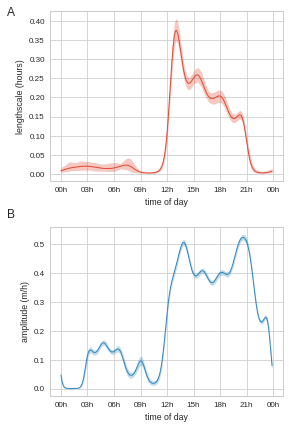

In [8]:
# i=3
# all_lengths = np.load('../data/full_len_sheep_p_' + str(i) + '.npy')
# all_amps = np.load('../data/full_amp_sheep_p_' + str(i) + '.npy')

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%Hh')


#amps = np.load('data/amps.npy')


gridsize = (2, 1)
fig = plt.figure(figsize=(4, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))

rescale=24
#Z = np.arange(0,1.0*rescale,rescale*0.001).astype(np.float64)[:,None]
Z = np.linspace(0,24,num=200,endpoint=False).astype(np.float64)[:,None]

#Z = np.arange(0,1.0*rescale,rescale*0.01).astype(np.float64)[:,None]


Z_time=np.array([np.datetime64('2019') - np.timedelta64(0, 'h') + np.timedelta64(int(k*60*60*24/rescale), 's') for k in Z])



ax1.plot(Z_time, np.mean(all_lengths, 0),c='C0', lw=1)

ax1.fill_between(Z_time[:],
                 np.percentile(all_lengths, 0.5, axis=0)[:,0],
                 np.percentile(all_lengths, 99.5, axis=0)[:,0],
                 color='C0', alpha = 0.3)

# #plt.xlim(0,1)
#ax1.set_ylim(0,0.2)

# #plt.xlim(0,1)
# ax = plt.gca()
ax1.xaxis_date()
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))


ax1.xaxis.set_major_formatter(myFmt)
# #plt.gcf autofmt_xdate()
ax1.set_xlabel('time of day')
ax1.set_ylabel('lengthscale (hours)')
#ax1.set_yticklabels([])





ax1.xaxis.set_major_formatter(myFmt)

ax2.plot(Z_time, np.mean(all_amps, 0),c='C1', lw=1) # x3.6 to convert m/s to km/h

ax2.fill_between(Z_time[:],
                 np.percentile(all_amps, 0.5, axis=0)[:,0],
                 np.percentile(all_amps, 99.5, axis=0)[:,0],
                 color='C1', alpha = 0.3)

# #plt.xlim(0,1)
#ax2.set_ylim(0,0.2)

# #plt.xlim(0,1)
# ax = plt.gca()
ax2.xaxis_date()
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))


ax2.xaxis.set_major_formatter(myFmt)
# #plt.gcf autofmt_xdate()
ax2.set_xlabel('time of day')
ax2.set_ylabel('amplitude (m/h)')
#ax2.set_yticklabels([])







plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .15, yp- .01, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .15, yp+ .02, 'B', size=12)

#plt.savefig('../figures/sheep_combined.png', dpi=300, bbox_inches = "tight")


In [34]:
burn=0
num_runs=2
num_samples=5000
samples = np.zeros((num_samples-burn,num_runs,24*2))
samples_t = np.zeros((num_samples-burn,num_runs,24*2))
all_lengths = np.zeros(((num_samples-burn)*num_runs,24,1))
all_amps = np.zeros(((num_samples-burn)*num_runs,24,1))

for i in range(num_runs):
    with open ('../data/hmc_samples_p_' + str(i) + '.npy', 'rb') as fp:
        hmcs = pickle.load(fp)
        print(len(hmcs[3]))
        lengths = np.load('../data/len_sheep_p_' + str(i) + '.npy')
        amps = np.load('../data/amp_sheep_p_' + str(i) + '.npy')
        samples[:,i,0:24] = hmcs[1][burn:,...]
        samples[:,i,24:] =  hmcs[3][burn:,...]
        samples_t[:,i,0:24] = lengths[...,0]#hmcs[1][burn:,...]
        samples_t[:,i,24:] =  amps[...,0]
    
    all_lengths[i*(num_samples-burn):(i+1)*(num_samples-burn),...] = lengths[burn:]
    all_amps[i*(num_samples-burn):(i+1)*(num_samples-burn),...] = amps[burn:]

5000
5000


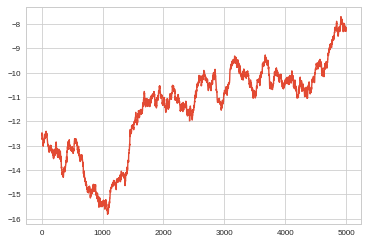

In [37]:
plt.plot(hmcs[1][:,1])
plt.show()

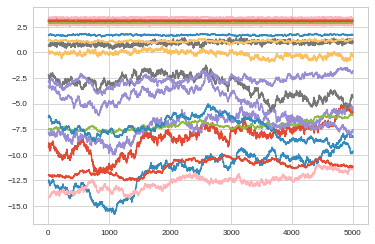

In [38]:
plt.plot(hmcs[1])
plt.show()

In [21]:
hmcs[1].shape

(5000, 48)

In [39]:
# 21/1/20 - getting very close with skip=1 - testing out NUTS next
samples_ = tf.convert_to_tensor(samples[::2])
rhat = tfp.mcmc.diagnostic.potential_scale_reduction(samples_, independent_chain_ndims=1)

samples_t_ = tf.convert_to_tensor(samples_t[::2])
rhat_t = tfp.mcmc.diagnostic.potential_scale_reduction(samples_t_, independent_chain_ndims=1)



In [42]:
rhat

<tf.Tensor: shape=(48,), dtype=float64, numpy=
array([1.003, 1.041, 1.094, 1.046, 1.116, 1.184, 1.069, 1.007, 1.115,
       1.217, 1.211, 1.093, 1.015, 1.004, 1.006, 1.005, 1.   , 1.001,
       1.001, 1.001, 1.002, 1.004, 1.016, 1.009, 1.   , 1.002, 1.002,
       1.   , 1.   , 1.002, 1.008, 1.021, 1.149, 1.197, 1.157, 1.096,
       1.024, 1.001, 1.001, 1.008, 1.   , 1.001, 1.   , 1.002, 1.001,
       1.   , 1.   , 1.   ])>

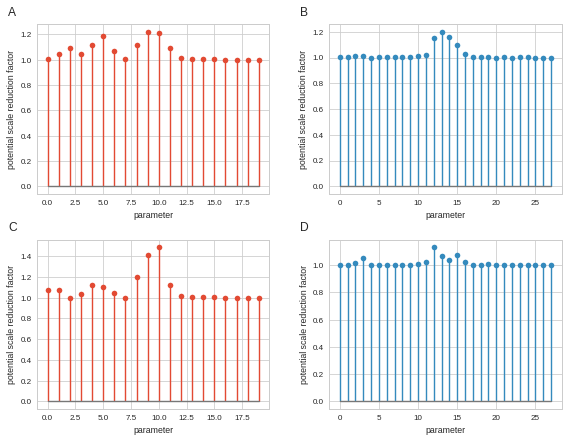

In [41]:


gridsize = (2, 2)
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0))
ax4 = plt.subplot2grid(gridsize, (1, 1))



ax1.stem(rhat[:20].numpy(),linefmt='C0-',markerfmt='C0o')
#ax1.set_ylim(1,1.2)

ax2.stem(rhat[20:].numpy(),linefmt='C1-',markerfmt='C1o')
#ax2.set_ylim(1,1.03)


ax3.stem(rhat_t[:20].numpy(),linefmt='C0-',markerfmt='C0o')
#ax3.set_ylim(1,1.12)

ax4.stem(rhat_t[20:].numpy(),linefmt='C1-',markerfmt='C1o')
#ax4.set_ylim(1,1.03)




# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# ax4.yaxis.set_major_locator(ticker.MultipleLocator(0.02))


ax1.set_ylabel('potential scale reduction factor')
ax1.set_xlabel('parameter')

ax2.set_ylabel('potential scale reduction factor')
ax2.set_xlabel('parameter')

ax3.set_ylabel('potential scale reduction factor')
ax3.set_xlabel('parameter')

ax4.set_ylabel('potential scale reduction factor')
ax4.set_xlabel('parameter')



plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .05, yp+ .02, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .05, yp+ .02, 'B', size=12)

xp = ax3.get_position().x0
yp = ax3.get_position().y1    
fig.text(xp - .05, yp+ .02, 'C', size=12)

xp = ax4.get_position().x0
yp = ax4.get_position().y1    
fig.text(xp - .05, yp+ .02, 'D', size=12)


#plt.savefig('../figures/srf.png', dpi=300, bbox_inches = "tight")
plt.show()
